# (10) Averaging filter.

In this worksheet we design a function that "filters" the Tanouchi formatted data such that every $n$ timepoints are averaged over. The purpose of this is to reduce the amount of rejection in the SMC-ABC algorithm and allow for better inference of temporal dynamics within each generation. In addition to this, the filter also helps to smooth out experimental noise from the Tanouchi trajectories.

We first import the data from the 37°C dataset.

In [87]:
using DelimitedFiles;
include("./extract_gens.jl"); using .extract;

In [88]:
filelist = readdir("Analysis_MC4100_37C/MC4100_37C/"); # take the file names - each file is for a different lineage.
raw_data = []; # define the raw data array.
for (i,file) in enumerate(filelist)
    push!(raw_data,readdlm(string("Analysis_MC4100_37C/MC4100_37C/", file), ',', Float64, '\n'))
end

In [126]:
fluor_all_lins = [raw_data[x][:,4] for x in 1:length(raw_data)]; # non-separated fluor data.
vol_all_lins = [raw_data[x][:,3] for x in 1:length(raw_data)]; # non-separated vol data.

fluor_sep_all_lins = extract_gens(raw_data,4); # the fluor. data for each lineage sep into gens.
vol_sep_all_lins = extract_gens(raw_data,3); # the vol. data for each lineage sep into gens.
times_sep_all_lins = extract_gens(raw_data,1); # the time pt data for each lineage sep into gens.

fpm = readdlm("MN_props.csv")[1];
exp_grs = readdlm("exp_grs_all.csv", ',', Float64, '\n');

num_sep_all_lins = []; # sep into gens.
conc_sep_all_lins = [];
for i in 1:length(fluor_sep_all_lins)
    num_i = fluor_sep_all_lins[i]./fpm;
    conc_i = [num_i[y] ./ vol_sep_all_lins[i][y] for y in 1:length(vol_sep_all_lins[i])];
    push!(num_sep_all_lins,num_i);
    push!(conc_sep_all_lins,conc_i);
end

# un-sep molecule number and concs for each lineage (including 70th gen to be removed) later).
num_all_lins = [fluor_all_lins[x]./fpm for x in 1:length(fluor_all_lins)];
conc_all_lins = [num_all_lins[x]./vol_all_lins[x] for x in 1:length(fluor_all_lins)];

v0_n0_th = []; # 2-d array to storing (1) the initial values of vol (2) molecule #  and (3) theta for each gen in each lin
for x in 1:length(fluor_all_lins) # the lin loop
    v0_n0_th_x = [];
    for y in 1:length(fluor_sep_all_lins[x]) # the gen loop 1 --> 69
        num = fluor_sep_all_lins[x][y][1]./fpm;
        push!(v0_n0_th_x, [vol_sep_all_lins[x][y][1], num, exp_grs[x,y]])
    end
    push!(v0_n0_th, v0_n0_th_x)
end

Let's have a look at the format of the `num_sep_all_lins[1]` array for the first generation. Our aim will be to procees each generation by applying the filter with respect to integer input $n$ - returning the `filtered_sep_lins` and `filtered_lins` array from the function.

In [14]:
using Statistics;

In [128]:
conc_sep_all_lins[1];

In [147]:
lin = conc_sep_all_lins[1]; # only contains first 69 gens.
filter_lin = []; # init the filtered array.
n = 7; # the width (i.e., # of time pts) of the filter.

for (i,gen) in enumerate(lin)
    filter_gen = []; # the filter array for each gen.
    div = length(gen) ÷ n; # the int division of the gen length by the filter width
    rem = length(gen) % n; # the remainder
    
    for j in 1:div # loop over each full filter width
        j_prev = j-1;
        val = ones(n) .* mean(gen[j_prev*n+1:j*n])
        append!(filter_gen, val) # store to filter gen array
    end
    val_rem = ones(length(gen) - div*n) .* mean(gen[div*n+1:length(gen)]) # also include the remainder.
    append!(filter_gen, val_rem)
    push!(filter_lin, filter_gen) # push to the lineage filter array.
end

In [148]:
#[filter_lin[1] lin[1]]; length(lin); cat(lin...,dims=1);

Let's plot the resulting filtered array of the lineage to make sure it makes sense.

In [149]:
using Plots, LaTeXStrings; pyplot()

Plots.PyPlotBackend()

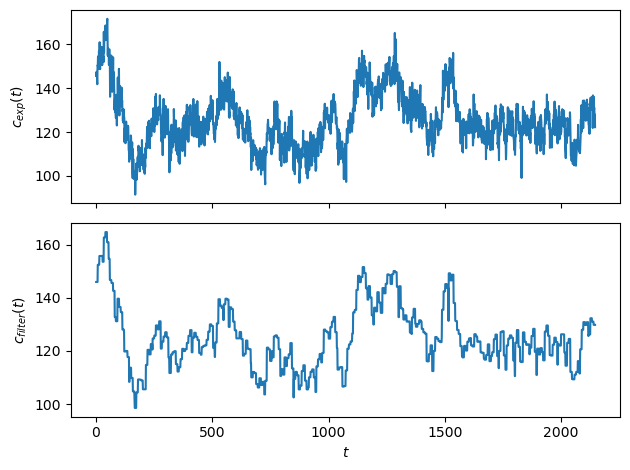

In [150]:
lin_all = cat(lin...,dims=1); filter_all = cat(filter_lin...,dims=1);

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{filter}(t)"); 
axs[1].plot(range(1,length(lin_all),step=1),lin_all); axs[2].plot(range(1,length(filter_all),step=1),filter_all);

## Modify code to a function that can be imported

- 1. `lin` the lineage of data in the form `Array{Array{Float64,1},1}`.
- 2. `n` the filter width.

In [132]:
function filter(lin::Array{Array{Float64,1},1}, n::Int64)
    filter_lin = []; # init the filtered array.
    for (i,gen) in enumerate(lin)
        
        filter_gen = []; # the filter array for each gen.
        div = length(gen) ÷ n; # the int division of the gen length by the filter width
        rem = length(gen) % n; # the remainder

        for j in 1:div # loop over each full filter width
            j_prev = j-1;
            val = ones(n) .* mean(gen[j_prev*n+1:j*n])
            append!(filter_gen, val) # store to filter gen array
        end
        
        val_rem = ones(length(gen) - div*n) .* mean(gen[div*n+1:length(gen)]) # also include the remainder.
        
        append!(filter_gen, val_rem)
        push!(filter_lin, filter_gen) # push to the lineage filter array.
    end
    return convert(Array{Array{Float64,1},1},filter_lin), cat(filter_lin...,dims=1) # return filtered lin in sep and un-sep form.
end

filter (generic function with 1 method)

Works well! Now to test on the inference in the next notebook. **We have added the above method to the extract_gens.jl file such that it can be imported in later programs.** Can also use the autocorrelation time to estimate the best width of the filter.

In [79]:
using StatsBase;

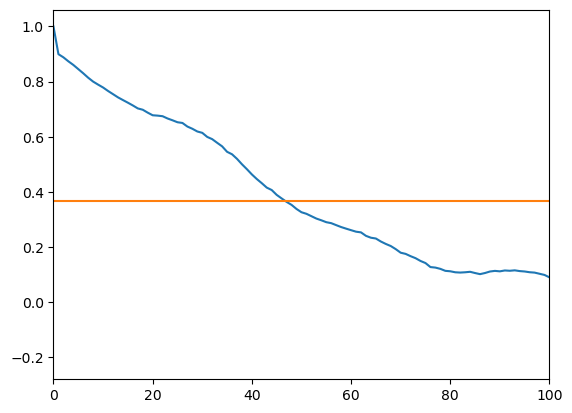

In [134]:
expt_ac = autocor(lin_all[:], range(0, length(lin_all[:])-1, step=1), demean = true);
fig, ax = PyPlot.subplots(1,1, sharex = true);
ax.plot(expt_ac); ax.plot(ones(length(expt_ac)).* exp(-1)); ax.set_xlim(0,100);

For the case of the first experimental lineage this seems to be around 40... Pick around $n=5$.